# Predicting math grades in ENEM 2016 exam
What is ENEM?
>   "O Exame Nacional do Ensino Médio (ENEM, or National High School Exam) is a non-mandatory, standardized Brazilian national exam, which evaluates high school students in Brazil. The ENEM is used as an admission exam for enrollment in many Universities in Brazil, as well as for a high school degree certification. The examination is likewise used by individuals wanting to earn points in 'the University for All Programme', or ProUni, a federal scholarship programme (Programa Universidade para Todos). The ENEM exam comprises of 180 multiple-choice questions and tests students in **five main areas**, namely natural sciences, math, human sciences, Portuguese and either English or Spanish as a foreign language. Students are also required to write an essay."  Font: [Brazil Education](https://www.brazileducation.info/tests/higher-education-tests/enem-in-brazil.html)

My analysis will consist on predicting the math grades in ENEM 2016 test by building a model that correctly predict grades with accuracy higher than 90%


In [1]:
import sklearn
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn.metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif, SelectFromModel


from IPython.display import display_html

In [2]:
# Reading dataset
path_test = r'dataset/test.csv'
path_train = r'dataset/train.csv'

test_raw = pd.read_csv(path_test)
train_raw = pd.read_csv(path_train)

In [3]:
test_raw.head(5)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,...,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,...,0.0,320.0,D,H,H,C,B,A,NaN,A


In [4]:
train_raw.head(5)

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


Since train and test dataset have different features available, I will use the features shared in both dataframes. However, I need to add my target variable, i.e. 'NU_NOTA_MT' in df_train.

In [5]:
# Create a train dataframe with same features in test
features = test_raw.columns.tolist() 
features.append('NU_NOTA_MT')
df_train = train_raw[features]
df_train.head(4)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,520.0,D,D,C,A,A,C,H,A,399.4
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,580.0,A,A,B,A,A,A,NaN,A,459.8
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,NaN,D,D,C,A,A,A,NaN,A,NaN
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,NaN,H,E,E,C,B,C,F,D,NaN


In [6]:
# Overiding jupyter style to plot dataframes side by side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Data understanding:
To better understand our features, we need to analyse it and check if we have any redundant variables that could be easily dropped.
Let's start this with data description:

*   **ID**: 'NU_INSCRICAO'

*   **Student**:    'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'IN_IDOSO', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'IN_SABATISTA'

*   **Student health**:  'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_GESTANTE'

*   **High school**:  'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU','TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC'

*  **Student exam info**: 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',  'TP_LINGUA'

*  **Grades**: 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',  'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC'

*  **Family background**: 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'

By splitting features in these categories we can easily check redundant information, for example:
>   CO_UF_RESIDENCIA (same info as SG_UF_RESIDENCIA)

>   IN_IDOSO (already specified in NU_IDADE)

In [7]:
# Drop columns
df_train = df_train.drop(['CO_UF_RESIDENCIA', 'IN_IDOSO', 'NU_INSCRICAO'], axis=1)
df_test = test_raw.drop(['CO_UF_RESIDENCIA', 'IN_IDOSO', 'NU_INSCRICAO'], axis=1)

print('Number of features: ', len(df_train.columns))

Number of features:  45


# Data Investigation
- Scatter plot between variables and target (math grade)
- Histogram 
- Boxplot (check outliers and data distribution - violin plot)

In [8]:
# Function to get numerical and categorical features
def cols_numeric_categ(df):
    numeric_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    return numeric_cols, categorical_cols

In [9]:
# Extract numerical variables
numeric, categorical = cols_numeric_categ(df_train)
print(f"Numerical features {len(numeric)}, Categorical features {len(categorical)}")

Numerical features 31, Categorical features 14


In [ ]:
# Scatterplot for numerical variables x math grades
sns.set_style("dark")
fig, axes = plt.subplots(figsize=(11,11), nrows=5, ncols=6, sharey=True)
axes = axes.flatten()

for feature, ax in zip(numeric, axes):
    sns.scatterplot(
        x=feature,
        y="NU_NOTA_MT",
        data=df_train,
        ax=ax)
    ax.set_title(feature, fontsize=8)
    
fig.tight_layout()

In [ ]:
# Violinplot for numerical variables x math grades
fig, axes = plt.subplots(figsize=(12,8), nrows=5, ncols=6, sharey=True)
axes = axes.flatten()

for feature, ax in zip(numeric, axes):
    sns.violinplot(
        x=feature,
        data=df_train,
        ax=ax)
    ax.set_title(feature, fontsize=8)
    
fig.tight_layout()

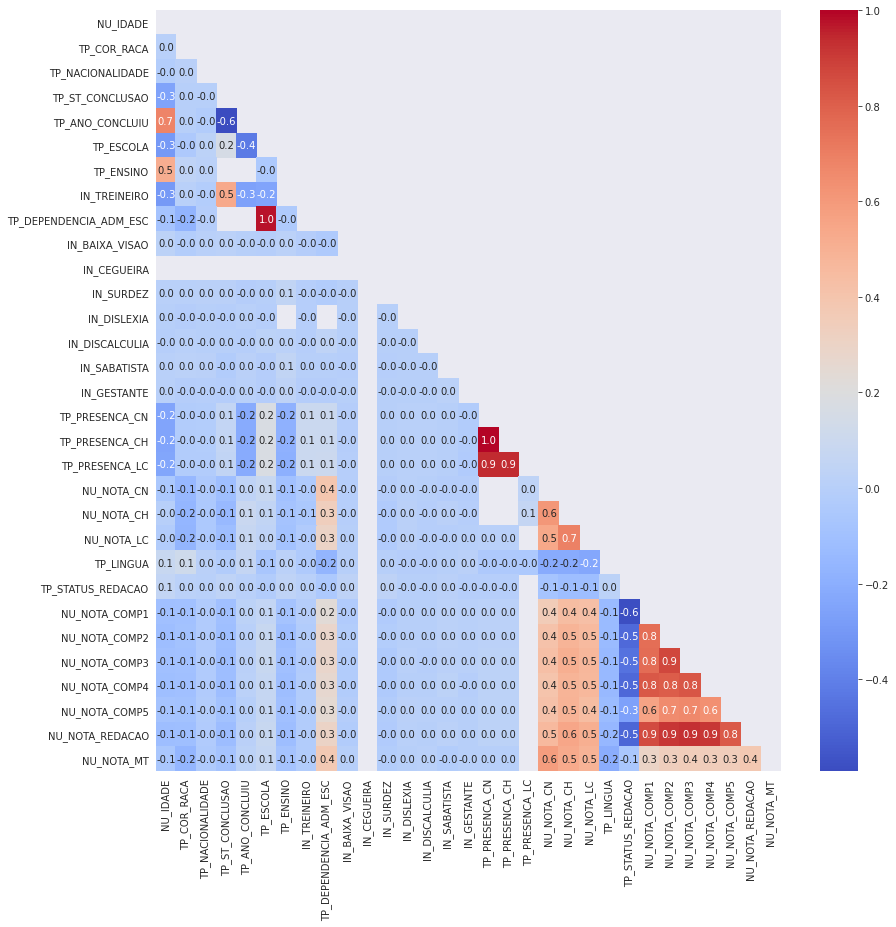

In [11]:
# Correlation
corr = df_train.corr()
mask = np.triu(corr)

fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(corr, cmap='coolwarm', mask=mask, annot=True, fmt='.1f')

Inside numerical features list there are categorical variables (for example, 'N_SABATISTA'). I will remove them from numerical list and put into categorical list

In [12]:
misplaced_features = [
    'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
    'TP_ANO_CONCLUIU',  'TP_ESCOLA',  'IN_TREINEIRO',
    'IN_BAIXA_VISAO', 'IN_CEGUEIRA',  'IN_SURDEZ',
    'IN_DISLEXIA', 'IN_DISCALCULIA',  'IN_SABATISTA',
    'IN_GESTANTE', 'TP_PRESENCA_CN','TP_PRESENCA_CH', 
    'TP_PRESENCA_LC',  'TP_LINGUA','TP_ENSINO', 
    'TP_DEPENDENCIA_ADM_ESC'
    ]

# Adding misplaced features to categorical list
[categorical.append(item) for item in misplaced_features]

# Removing misplaced from numeric list
numeric = [item for item in numeric if item not in misplaced_features]
numeric

['NU_IDADE',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'NU_NOTA_MT']

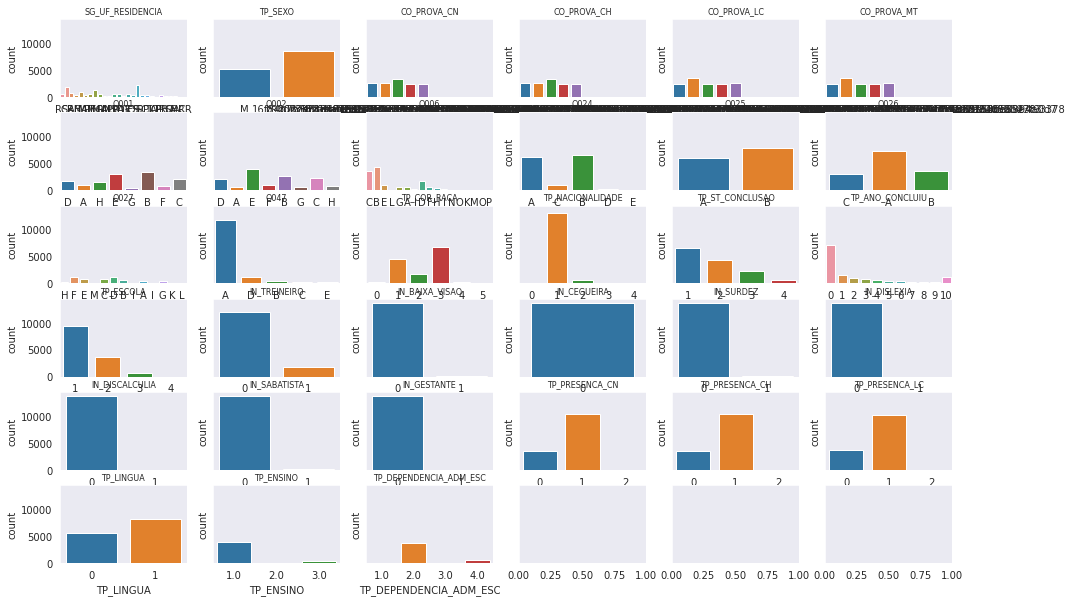

In [13]:
# Barplot for value_counts to categorical variables 
fig, axes = plt.subplots(figsize=(16,10), nrows=6, ncols=6, sharey=True)
axes = axes.flatten()

for feature, ax in zip(categorical, axes):
    ax.set_title(feature, fontsize=8)
    sns.countplot(
        x=feature, 
        data=df_train,
        ax=ax)

Since some of features doesn't add too much information (variance) into data, or are extremelly unbalanced I will drop them

In [14]:
# Function to drop columns
def drop_columns(dataframe, columns_list):
    dataframe = dataframe.drop(columns_list, axis='columns')
    return dataframe

In [15]:
cat_irrelevant = [    
    'IN_BAIXA_VISAO','IN_CEGUEIRA', 'IN_SURDEZ', 
    'IN_DISLEXIA','IN_DISCALCULIA', 'IN_SABATISTA', 
    'IN_GESTANTE', 'TP_NACIONALIDADE'
    ]
# Removing it fom categorical list
categorical = [item for item in categorical if item not in cat_irrelevant]

# Dropping it from dataframe
df_train = drop_columns(df_train, cat_irrelevant)
df_test = drop_columns(df_test, cat_irrelevant)

# Handling Missing data
Let's find out how messy is the dataset

In [16]:
# Function to check missing data
def missing_data(dataframe):
    missing = pd.DataFrame({'dtype': dataframe.dtypes,
                            'unique vals': dataframe.nunique(),
                            'missing%': (dataframe.isna().sum() / dataframe.shape[0]) * 100})
    # Get columns with missing% greater than 0
    missing = missing[missing['missing%'] > 0]
    missing = missing.sort_values('missing%', ascending=False)
    
    # Columns name with missing% greater than 60%
    cols_missing_50 = list(missing[missing['missing%'] > 50].index)
    
    return missing, cols_missing_50

In [17]:
# Check missing data
dftest_missing, missing_test_cols50 = missing_data(df_test)
dftrain_missing, missing_train_cols50 = missing_data(df_train)

# Checking
display_side_by_side(dftest_missing, dftrain_missing)

,dtype,unique vals,missing%
TP_ENSINO,float64,3,67.657343
TP_DEPENDENCIA_ADM_ESC,float64,4,67.657343
Q027,object,13,54.370629
NU_NOTA_LC,float64,1839,26.201923
TP_STATUS_REDACAO,float64,9,26.201923
NU_NOTA_COMP1,float64,10,26.201923
NU_NOTA_COMP2,float64,10,26.201923
NU_NOTA_COMP3,float64,11,26.201923
NU_NOTA_COMP4,float64,11,26.201923
NU_NOTA_COMP5,float64,11,26.201923


In [18]:
# Drop columns with missing% > 50
df_test = drop_columns(df_test, missing_test_cols50)
df_train = drop_columns(df_train, missing_train_cols50)

# Also, lets drop this in categorical list
for item in missing_train_cols50:
    categorical.remove(item)

In [19]:
# Check categorical features and dtypes
df_train[categorical].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 22 columns):
SG_UF_RESIDENCIA    13730 non-null object
TP_SEXO             13730 non-null object
CO_PROVA_CN         13730 non-null object
CO_PROVA_CH         13730 non-null object
CO_PROVA_LC         13730 non-null object
CO_PROVA_MT         13730 non-null object
Q001                13730 non-null object
Q002                13730 non-null object
Q006                13730 non-null object
Q024                13730 non-null object
Q025                13730 non-null object
Q026                13730 non-null object
Q047                13730 non-null object
TP_COR_RACA         13730 non-null int64
TP_ST_CONCLUSAO     13730 non-null int64
TP_ANO_CONCLUIU     13730 non-null int64
TP_ESCOLA           13730 non-null int64
IN_TREINEIRO        13730 non-null int64
TP_PRESENCA_CN      13730 non-null int64
TP_PRESENCA_CH      13730 non-null int64
TP_PRESENCA_LC      13730 non-null int64
TP_LINGUA        

In [20]:
# Check numerical features and dtypes
df_train[numeric].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 12 columns):
NU_IDADE             13730 non-null int64
NU_NOTA_CN           10341 non-null float64
NU_NOTA_CH           10341 non-null float64
NU_NOTA_LC           10133 non-null float64
TP_STATUS_REDACAO    10133 non-null float64
NU_NOTA_COMP1        10133 non-null float64
NU_NOTA_COMP2        10133 non-null float64
NU_NOTA_COMP3        10133 non-null float64
NU_NOTA_COMP4        10133 non-null float64
NU_NOTA_COMP5        10133 non-null float64
NU_NOTA_REDACAO      10133 non-null float64
NU_NOTA_MT           10133 non-null float64
dtypes: float64(11), int64(1)
memory usage: 1.3 MB


In [21]:
# Check if student was absent on exam when grades are missing 
def fill_grades(dataframe, subject):
    condition = dataframe[
        (dataframe['TP_PRESENCA_CN'] == 0) & 
        (dataframe['TP_PRESENCA_CH'] == 0) &
        (dataframe['TP_PRESENCA_LC'] == 0)
        ].index
    # If student wasn't take the exam I fill math grades with 0
    dataframe.loc[condition, subject] = dataframe.loc[condition,subject].fillna(0)
    
    return dataframe

In [22]:
# Filling in df_train
for col in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_STATUS_REDACAO']:
    df_train = fill_grades(df_train, col)

# Filling in df_test
for col in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_STATUS_REDACAO']:
    df_test = fill_grades(df_test, col)

# Displaying
display_side_by_side(
    df_train[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_STATUS_REDACAO']].head(7),
    df_test[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_STATUS_REDACAO']].head(7))

NU_NOTA_CN 
 NU_NOTA_CH 
 NU_NOTA_LC 
 NU_NOTA_MT 
 TP_STATUS_REDACAO 
 
 
 
 
 0 
 436.3 
 495.4 
 581.2 
 399.4 
 1.0 
 
 
 1 
 474.5 
 544.1 
 599.0 
 459.8 
 1.0 
 
 
 2 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 3 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 4 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 5 
 439.7 
 583.2 
 410.9 
 364.5 
 1.0 
 
 
 6 
 420.1 
 604.2 
 484.5 
 529.2 
 1.0 
 
 
 
 
 
 
 NU_NOTA_CN 
 NU_NOTA_CH 
 NU_NOTA_LC 
 TP_STATUS_REDACAO 
 
 
 
 
 0 
 464.8 
 443.5 
 431.8 
 1.0 
 
 
 1 
 391.1 
 491.1 
 548.0 
 1.0 
 
 
 2 
 595.9 
 622.7 
 613.6 
 1.0 
 
 
 3 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 4 
 592.9 
 492.6 
 571.4 
 1.0 
 
 
 5 
 414.5 
 568.5 
 542.5 
 1.0 
 
 
 6 
 485.7 
 654.6 
 606.6 
 1.0

# Predicting
## Random Forest Approach
Steps:
*   Fill missing data
*   Make a GridSearch to look for best parameters
*   Fit model
*   Select best model and best parameters
*   Re-fit best model
*   Predict for test dataset

**Additional Info**:
*   Random Forest tunning [resource1](https://www.alura.com.br/conteudo/machine-learning-otimizacao-com-exploracao-aleatoria), 
[resource2](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
*  Feature selection using RF [resource3](https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/)
*   [Categorical data for ensemblers](https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree)
*   https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
*   [RF for feature selection](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)
*   Why not normalize data? Check this [discussion](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package)
----------
Why not use PCA: 
>   Well, isn't a good idea do this with categorical variables, check these discussions [1st](https://stackoverflow.com/questions/40795141/pca-for-categorical-features) and [2nd](https://www.kaggle.com/general/21449)

----------
Further questions: 

*  [1st](https://github.com/scikit-learn-contrib/sklearn-pandas#categoricalimputer) That's a difference between CatergoricalImputer and SimpleImputer for categorical variables?


https://machinelearningmastery.com/feature-selection-with-categorical-data/
https://www.tomasbeuzen.com/post/scikit-learn-gridsearch-pipelines/


In [23]:
# Numerical Pipeline
num_pip = Pipeline(
    steps=[
        ('input', SimpleImputer(missing_values=np.nan, strategy='mean'))
        ])

# Categorical Pipeline for Ensembler
cat_pip = Pipeline(
    steps=[
        ('input', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing'))
        ])

# Join both Pipelines with ColumnTransformer
preprocess_pipe = ColumnTransformer(
    transformers=[
                ('numerical', num_pip, numeric),
                ('categorical', cat_pip, categorical)
                ])

### Feature selection using RF
**Step by step**
*   Preprocess (fill missing data)
*   Encode variables using LabelEncoder
   >   OneHotEncoder not perform well with Ensembles methods:
   
   >   "One-hot encoding categorical variables with high cardinality can cause inefficiency in tree-based ensembles. Continuous variables will be given more importance than the dummy variables by the algorithm which will obscure the order of feature importance resulting in poorer performance." [Font 1](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)

In [24]:
# Train data
# 1st: Preprocessing (fill missing data)
preprocess_ = preprocess_pipe.fit_transform(df_train)
train_processed = pd.DataFrame(preprocess_, columns=(numeric+categorical))

# 2nd: Label Encoder for categorical
le = LabelEncoder()
for col in categorical:
    train_processed[col] = le.fit_transform(train_processed[col].values)

# Setting X and Y variables
X = train_processed[numeric[:-1] + categorical]
Y = train_processed.loc[:, 'NU_NOTA_MT']

# Split train
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.30, random_state=13)

print('Training Features Shape:', train_x.shape)
print('Training target Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing target Shape:', test_y.shape)

Training Features Shape: (9611, 33)
Training target Shape: (9611,)
Testing Features Shape: (4119, 33)
Testing target Shape: (4119,)


In [25]:
# Running RandomForest Regressor
%timeit
# https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

# RandomForest 
rf = RandomForestRegressor(random_state=13)

parameters = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [50, 100, 150],
    'min_samples_split': [5, 20, 50],
    'min_samples_leaf': [5, 20],
    'bootstrap': [True], 
    'oob_score': [True]
}

# Grid search
model_rf = GridSearchCV(
    estimator=rf,
    param_grid=parameters, 
    cv=KFold(n_splits=5, shuffle=True),
    n_jobs=-1
)

# Fitting
model_rf.fit(train_x, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [50, 100, 150],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 20],
                         'min_samples_split': [5, 20, 50],
                         'n_estimators': [50, 100, 150], 'oob_score': [True]})

In [26]:
# Find best parameters
print(f"Best parameters {model_rf.best_params_} \n")
print(f"Best score: {model_rf.best_score_ * 100} ")

model_result = pd.DataFrame(model_rf.cv_results_)

Best parameters {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 150, 'oob_score': True} 

Best score: 92.09514939829396 


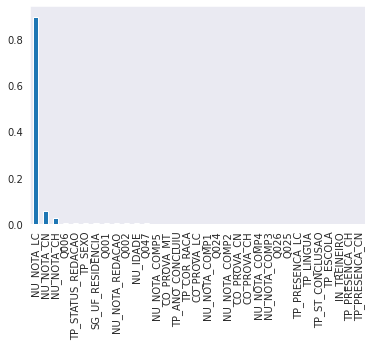

In [27]:
# Best model: model_rf.best_estimator_
# Plotting feature importance

feature_scores = model_rf.best_estimator_.feature_importances_
feature_scores = pd.Series(feature_scores, index=train_x.columns).sort_values(ascending=False)
feature_scores.plot(kind='bar')

In [28]:
# Selecting from model
sfm = SelectFromModel(model_rf.best_estimator_, threshold=0.01)

# Train the selector
sfm.fit(train_x, train_y)

# Print the names of the most important features
all_features = train_x.columns.tolist()

for feature_list_index in sfm.get_support(indices=True):
    print(all_features[feature_list_index])

NU_NOTA_CN
NU_NOTA_CH
NU_NOTA_LC


In [39]:
# Predicting
predict_test_y = model_rf.best_estimator_.predict(test_x)

# Evaluating
mse = mean_squared_error(test_y, predict_test_y)
mse

4016.6712521095737

####################
### Fitting without removing features

In [37]:
# Pipeline for processing df_test
pipe_preprocess_test = ColumnTransformer(
    transformers=[
                ('numerical', num_pip, numeric[:-1]), # dados de treino
                ('categorical', cat_pip, categorical)
                ])

# 1st: Preprocessing (fill missing data)
preprocess_ = pipe_preprocess_test.fit_transform(df_test)
test_processed = pd.DataFrame(preprocess_, columns=(numeric[:-1]+categorical))

# 2nd: Label Encoder for categorical
le = LabelEncoder()
for col in categorical:
    test_processed[col] = le.fit_transform(test_processed[col].values)

# Predicting
predict = model_rf.best_estimator_.predict(test_processed)
predict_results = pd.DataFrame(
    {'NU_INSCRICAO': test_raw['NU_INSCRICAO'],
    'nota_predict': predict
    })
predict_results.head(4)

,NU_INSCRICAO,nota_predict
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,435.584315
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,438.579350
2,b38a03232f43b11c9d0788abaf060f7366053b6d,604.246792
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000


### Fitting using selected features


In [50]:
select_features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']

# Fit
model_rf.fit(train_x[select_features], train_y)

# Find best parameters
print(f"Best parameters {model_rf.best_params_} \n")
print(f"Best score: {model_rf.best_score_ * 100} ")

Best parameters {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 150, 'oob_score': True} 

Best score: 91.52651043692778 


In [71]:
# Predicting
predict_test_y2 = model_rf.best_estimator_.predict(test_x[select_features])

# Evaluating
mse = metrics.mean_absolute_error(predict_test_y2, test_y)
mae = metrics.mean_squared_error(test_y, predict_test_y2)
rmse = np.sqrt(mae)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 4286.175769414287
Mean Squared Error (MSE): 44.457268992683304
Root Mean Squared Error (RMSE): 65.46889161589867


In [119]:
# Exporting to csv
predict_results.to_csv('./result_prediction.csv')